# Can we predict the specie at hand if we input the percentages of it in t1,t2,t3 per a sample and the water conditions?

In [2]:
import pandas as pd
import torch
import numpy as np
from tqdm import tqdm

In [3]:
conditions_df = pd.read_csv("conditions_df.csv")
conditions_df.head()

,time,TAN_DF,pH_DF,NO2_DF,Alkalinity_DF,TAN_DGS,pH_DGS,NO2_DGS,Alkalinity_DGS,Flow_rate,...,TAN_removal_biocarrier,co2_mgl,h2s_ugl,o2_mgl,o2_sat,salinity,temp,sample_name,System,TimeStamp
0,29/08/2022 08:30,0.24,7.880,0.64,342.4,0.18,7.860,0.71,344.0,60.0,...,0.000034,7.03,0.16,7.79,83.78,14.88,15.1,B1_1,B,1
1,29/08/2022 08:31,0.28,8.070,0.64,433.4,0.22,8.020,0.55,433.9,60.0,...,0.000038,4.93,0.32,8.41,89.33,13.02,15.1,A1_1,A,1
2,05/09/2022 08:30,0.16,7.600,0.46,234.0,0.12,7.900,0.62,234.0,60.0,...,0.000023,8.76,0.13,7.57,81.98,16.36,15.3,B1_2,B,2
3,05/09/2022 08:31,0.15,7.700,0.46,233.4,0.04,8.000,0.35,232.0,60.0,...,0.000070,7.61,0.20,8.20,86.99,13.89,15.0,A1_2,A,2
4,12/09/2022 08:30,0.16,7.565,0.27,204.4,0.09,7.828,0.22,218.3,60.0,...,0.000050,9.08,0.11,7.40,82.05,16.98,15.2,B1_3,B,3


In [4]:
species_df = pd.read_csv("sample_by_specie_timewise.csv")
species_df.fillna(0,inplace=True)
species_df.head()

,id,Specie,System,Treatment,Replica,t1,t2,t3,slope,var,std,mean
0,Homo sapiens_A1_A,Homo sapiens,A,1,A,0.262329,0.327225,0.831947,0.284809,0.064824,0.254606,0.473834
1,Homo sapiens_A1_B,Homo sapiens,A,1,B,0.318878,0.447284,0.941915,0.311519,0.072147,0.268602,0.569359
2,Homo sapiens_A1_C,Homo sapiens,A,1,C,0.286041,0.518135,0.730994,0.222476,0.033018,0.181708,0.511723
3,Homo sapiens_A2_A,Homo sapiens,A,2,A,0.641026,0.587084,0.000000,-0.320513,0.084277,0.290305,0.409370
4,Homo sapiens_A2_B,Homo sapiens,A,2,B,0.729927,0.543478,0.000000,-0.364964,0.095881,0.309646,0.424468


In [5]:
class Dataset():
    def __init__(self, species_df, conditions):
        self.species_df = species_df
        self.conditions = conditions

        #diferent species
        self.species_vocab = species_df["Specie"].unique().tolist()

    
    def __len__(self):
        return len(self.species_df)
    
    def __getitem__(self, idx):
        assert ((idx >= 0) & (idx < self.__len__())), "Dataset index out of range"

        row =  self.species_df.iloc[idx]
        percents =row[["t1","t2","t3"]].tolist()
        y = self.species_vocab.index(row["Specie"]) #one hot specie

        cond_by_t = []
        for t in range(1,4):
            conditions = self.conditions[(self.conditions["System"] == row["System"]) & (self.conditions["Treatment"] == row["Treatment"]) & (self.conditions["TimeStamp"] == t)]
            if len(conditions) == 0:
                cond_by_t.append([0]*len(conditions.columns))
            else:
                cond_by_t.append(conditions.iloc[0].tolist())


        return  cond_by_t, percents , y

In [6]:
dataset = Dataset(species_df,conditions_df)
dataset.__getitem__(6)

([['03/10/2022 08:31',
   0.18,
   7.2,
   0.16,
   104.5,
   0.1,
   7.4,
   0.12,
   105.0,
   60.0,
   3,
   1,
   5.94530321046e-05,
   8.63,
   0.28,
   8.05,
   86.84,
   15.0,
   15.0,
   'A3_1',
   'A',
   1],
  ['10/10/2022 08:31',
   0.29,
   7.273,
   0.23,
   112.5,
   0.14,
   7.56,
   0.18,
   109.8,
   60.0,
   3,
   1,
   0.0001114744351961,
   11.44,
   0.24,
   7.63,
   83.53,
   14.79,
   14.9,
   'A3_2',
   'A',
   2],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]],
 [0.487012987012987, 0.4201680672268907, 0.0],
 0)

Use this dataset to calculate correlations between the percentages over t and each of the different columns over t

In [12]:
import warnings
warnings.filterwarnings("ignore", message="invalid value encountered in divide", category=RuntimeWarning)

In [27]:
indices_to_remove = [0, 10, 11, 19, 20, 21]
columns = list(conditions_df.columns)
corr_columns = [columns[i] for i in range(len(columns)) if i not in indices_to_remove]
print(corr_columns)

['TAN_DF', 'pH_DF', 'NO2_DF', 'Alkalinity_DF', 'TAN_DGS', 'pH_DGS', 'NO2_DGS', 'Alkalinity_DGS', 'Flow_rate', 'TAN_removal_biocarrier', 'co2_mgl', 'h2s_ugl', 'o2_mgl', 'o2_sat', 'salinity', 'temp']


In [54]:
correlations = {lab:[] for lab in corr_columns}
for i in tqdm(range(len(dataset))):
    conditions, values, specie  = dataset.__getitem__(i)
    for col in corr_columns:
        col_idx = columns.index(col)
        filt_cond_byt = np.array(conditions)[:,col_idx]
        filt_cond_byt = filt_cond_byt.astype("float")
        if np.isnan(values).all() or np.isnan(filt_cond_byt).all() :
            correlations[col].append(np.nan)
        else:
            corr = np.corrcoef(values,filt_cond_byt)
            correlations[col].append(corr[1,0])


  1%|          | 4364/684992 [00:09<25:07, 451.59it/s]Process SpawnPoolWorker-70:

Traceback (most recent call last):
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/pool.py", line 114, in worker
    task = get()
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/queues.py", line 365, in get
    with self._rlock:
  File "/Library/Developer/CommandLineTools/Library/Frameworks/Python3.framework/Versions/3.9/lib/python3.9/multiprocessing/synchronize.py", line 95, in __enter

KeyboardInterrupt: 

In [ ]:
species_df.to_csv("final_species_df.csv")

Analyzing the distribution of correlations.

In [40]:
import matplotlib.pyplot as plt

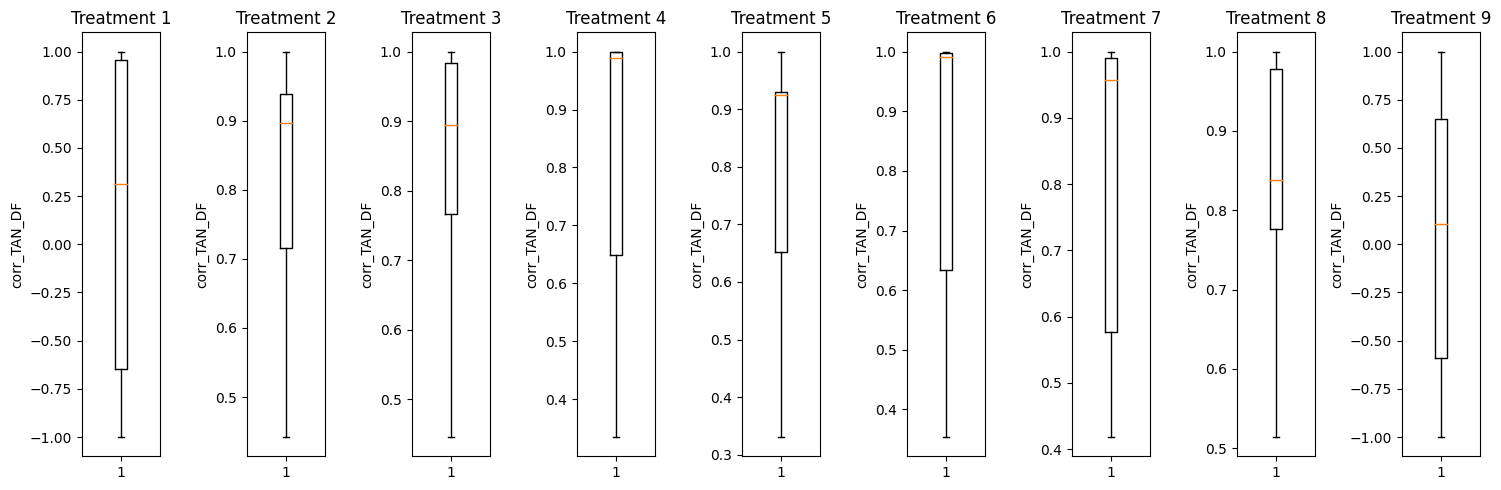

In [51]:
for group in ["Sytem","Treatment"]:
    for col in corr_columns:
        unique_treatments = species_df[group].unique()

        # Create a subplot with multiple axes arranged in a grid
        fig, axes = plt.subplots(1, len(unique_treatments), figsize=(15, 5))

        # Iterate through unique treatments and create box plots
        for i, treatment in enumerate(unique_treatments):
            ax = axes[i]
            filtered_data = species_df[species_df[group] == treatment]["corr_"+col].dropna()
            ax.boxplot(filtered_data, showfliers=False)
            ax.set_ylabel("corr_"+col)
            ax.set_title(f"{group}: {treatment}")

        # Adjust the layout to prevent overlap
        plt.tight_layout()

        # Show the box plots
        plt.show()

Analyzing distribution by replicas.

Cannot do it on all species, but some yes.

In [ ]:
spsc2plot =  species_df["Species"].unique()[:2]
for group in spsc2plot:
    for col in corr_columns:
        unique_treatments = species_df[group].unique()

        # Create a subplot with multiple axes arranged in a grid
        fig, axes = plt.subplots(1, len(unique_treatments), figsize=(15, 5))

        # Iterate through unique treatments and create box plots
        for i, treatment in enumerate(unique_treatments):
            ax = axes[i]
            filtered_data = species_df[species_df[group] == treatment]["corr_"+col].dropna()
            ax.boxplot(filtered_data, showfliers=False)
            ax.set_ylabel("corr_"+col)
            ax.set_title(f"{group}: {treatment}")

        # Adjust the layout to prevent overlap
        plt.tight_layout()

        # Show the box plots
        plt.show()